In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 数据加载

### 创建dataset
- 加载MNIST数据
- 进行数据预处理, 转换为tensor

### 创建dataloader
- 将dataset传入dataloader, 设置batchsize

In [5]:
# 将数据集合下载到指定目录下,这里的transform表示，数据加载时所需要做的预处理操作

# 加载训练集合(Train)
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

# 加载测试集合(Test)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())
print(train_dataset) # 训练集
print(test_dataset) # 测试集

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
batch_size = 100
# 根据数据集定义数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

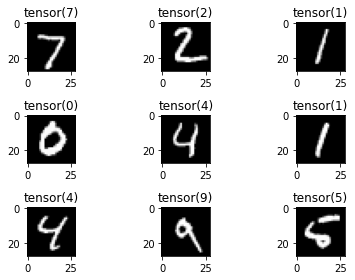

In [16]:
# 查看数据
examples = iter(test_loader)
example_data, example_target = examples.next() # 100*1*28*28

for i in range(9):
    plt.subplot(3,3,i+1).set_title(example_target[i])
    plt.imshow(example_data[i][0], 'gray')

plt.tight_layout()
plt.show()

## 网络的构建


In [41]:
# 输入节点数就为图片的大小：28×28×1
input_size = 784
# 由于数字为 0-9，因此是10分类问题，因此输出节点数为 10
num_classes = 10

# 网络的建立
class NeuralNet(nn.Module):
    # 输入数据的维度，中间层的节点数，输出数据的维度
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.relu(self.l1(x))
        out = self.l2(out)
        return out


model = NeuralNet(input_size, 500, num_classes).to(device)
model

NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)

In [42]:
# 简单测试模型的输出
examples = iter(test_loader)
example_data, _ = examples.next() # 100*1*28*28

model(example_data.reshape(example_data.size(0),-1)).shape

torch.Size([100, 10])

## 定义损失函数和优化器

In [43]:
# 定义学习率
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 模型的训练与测试

In [44]:
num_epochs = 10
n_total_steps = len(train_loader)

LossList = [] # 记录每一个epoch的loss
AccuryList = [] # 每一个epoch的accury

for epoch in range(num_epochs):
    # -------
    # 开始训练
    # -------
    model.train() # 切换为训练模型
    totalLoss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device) # 图片大小转换
        labels = labels.to(device)

        # 正向传播以及损失的求取
        outputs = model(images)
        loss = criterion(outputs, labels)
        totalLoss = totalLoss + loss.item()

        # 反向传播
        optimizer.zero_grad() # 梯度清空
        loss.backward() # 反向传播
        optimizer.step() # 权重更新

        if (i+1) % 300 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, n_total_steps, totalLoss/(i+1)))
    
    LossList.append(totalLoss/(i+1))

    # ---------
    # 开始测试
    # ---------
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1) # 预测的结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100.0 * correct / total # 在测试集上总的准确率
        AccuryList.append(acc)
        print('Accuracy of the network on the {} test images: {} %'.format(total, acc))

print("模型训练完成")

Epoch [1/10], Step [300/600], Loss: 0.3928
Epoch [1/10], Step [600/600], Loss: 0.2928
Accuracy of the network on the 10000 test images: 95.96 %
Epoch [2/10], Step [300/600], Loss: 0.1281
Epoch [2/10], Step [600/600], Loss: 0.1169
Accuracy of the network on the 10000 test images: 97.0 %
Epoch [3/10], Step [300/600], Loss: 0.0778
Epoch [3/10], Step [600/600], Loss: 0.0757
Accuracy of the network on the 10000 test images: 97.32 %
Epoch [4/10], Step [300/600], Loss: 0.0538
Epoch [4/10], Step [600/600], Loss: 0.0544
Accuracy of the network on the 10000 test images: 97.94 %
Epoch [5/10], Step [300/600], Loss: 0.0360
Epoch [5/10], Step [600/600], Loss: 0.0394
Accuracy of the network on the 10000 test images: 97.94 %
Epoch [6/10], Step [300/600], Loss: 0.0275
Epoch [6/10], Step [600/600], Loss: 0.0304
Accuracy of the network on the 10000 test images: 97.94 %
Epoch [7/10], Step [300/600], Loss: 0.0207
Epoch [7/10], Step [600/600], Loss: 0.0224
Accuracy of the network on the 10000 test images: 9

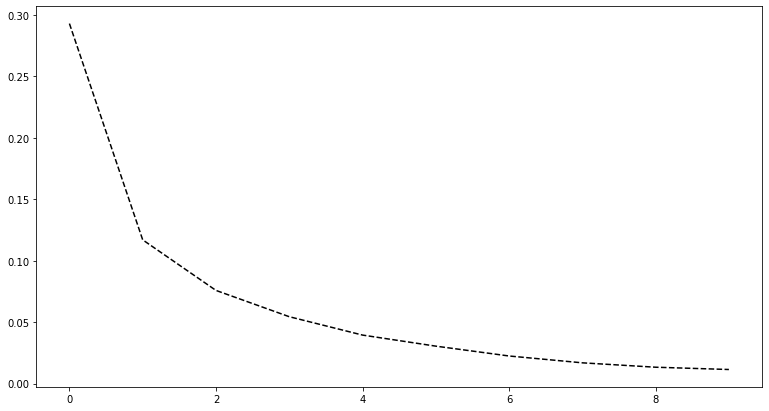

In [45]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(LossList, 'k--')

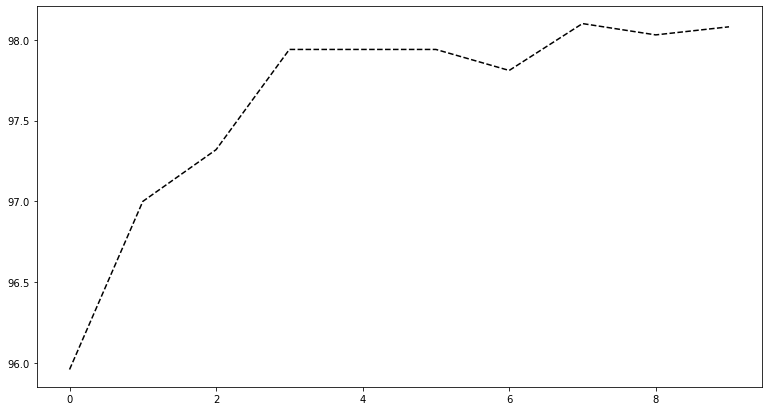

In [46]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(AccuryList, 'k--')

## 使用实际例子进行验证

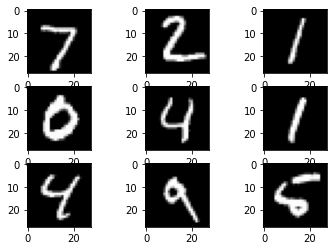

上面三张图片的真实结果： [7 2 1 0 4 1 4 9 5]
上面三张图片的预测结果： [7 2 1 0 4 1 4 9 5]


In [47]:
# 测试样例
examples = iter(test_loader)
example_data, example_targets = examples.next()

# 实际图片
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

# 结果的预测
images = example_data
images = images.reshape(-1, 28*28).to(device)
labels = labels.to(device)

# 正向传播以及损失的求取
outputs = model(images)
# 将 Tensor 类型的变量 example_targets 转为 numpy 类型的，方便展示
print("上面三张图片的真实结果：", example_targets[0:9].detach().numpy())
# 将得到预测结果
# 由于预测结果是 N×10 的矩阵，因此利用 np.argmax 函数取每行最大的那个值，最为预测值
print("上面三张图片的预测结果：", np.argmax(outputs[0:9].detach().numpy(), axis=1))